In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import scipy.stats as stats

import dataframe_image as dfi

warnings.filterwarnings('ignore')

- In order to replicate this assignment, I create a github repo.

There are four datasets: case.csv, demo.csv, prior_arrests.csv, and grades.csv. case.csv is the main
dataset and reflects dates of arrest and disposition (trial or court appearance) during the period in
which the program operated. The file also contains an indicator of whether the arrestee was referred
to the intervention program for that arrest (i.e. whether they were treated), whether the person was rearrested while awaiting trial, the number of prior arrests at the time of program entry, and the arrest
location. demo.csv contains demographic information about arrestees, including some who were not
included in the program evaluation. prior_arrests.csv reflects pre-period arrests among individuals in
case.csv; the pre-period ran from 2008-2011. Finally, grades.csv includes 9th and 10th grade course
grades for a subset of individuals in case.csv. Further description of the datasets is included at the end
of this document.

| Tables   |      Are      |  Cool |
|----------|:-------------:|------:|
| case|  main dataset | dates of arrest, diposition and referred indicator treatment |
| demo |    demographic info   |   arrestees info |
| prior arrests | pre period arrest |    from 2008 - 2011 |
|grades|9th to 10th grades|

## 1. Data Management


1. The demographic data were extracted from a system that inconsistently coded gender.
Recode it so that males are consistently coded as “M” and females are consistently coded as
“F”


In [130]:
demo = pd.read_csv('../raw_data/demo.csv')
demo.head()

,person_id,race,gender,bdate
0,1,WHITE,F,1985-07-03
1,5,BLACK,M,1986-09-27
2,6,BLACK,M,1991-06-07
3,7,BLACK,F,1994-08-24
4,8,BLACK,M,1978-04-04


In [131]:
#we can see that there more than 2 values for the gender, that must change
demo.gender.value_counts().to_frame()


,gender
M,15241
F,3804
male,1164
female,227


In [132]:
demo['gender'] = demo.gender.replace({'male':'M','female':'F'})

In [133]:
demo.gender.value_counts().to_frame()
#now we only got the desired values

,gender
M,16405
F,4031


2. Merge the case and demo datasets together so that each row in the case dataset also contains
the demographics of the defendant. Keep in mind that the populations in the case and demo
data may not be 100% aligned.

In [134]:
#reading the data
cases = pd.read_csv('../raw_data/case.csv')

In [135]:
#lets see how many rows and columns are 
print(f'Rows:{demo.shape[0]}\nColumns: {demo.shape[1]}')
demo.head(5)


Rows:20436
Columns: 4


,person_id,race,gender,bdate
0,1,WHITE,F,1985-07-03
1,5,BLACK,M,1986-09-27
2,6,BLACK,M,1991-06-07
3,7,BLACK,F,1994-08-24
4,8,BLACK,M,1978-04-04


In [136]:
#we have to verify if the demo dataset have any duplicated row
print( f'There are {demo.duplicated().sum()} replicated rows on the demo dataset')
#there are 4721 duplicated rows so we have to drop this rows in orde to erge our dataset

There are 4721 replicated rows on the demo dataset


In [137]:
#dropping the replicated rows
demo.drop_duplicates(inplace=True)
demo.shape
#now we got unique rows

(15715, 4)

In [138]:
#now for the cases dataset
print(f'Rows:{cases.shape[0]}\nColumns: {cases.shape[1]}')

cases.head(5)

Rows:26000
Columns: 8


,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO"
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO"
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO"
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO"
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO"


In [139]:
print( f'There are {cases.duplicated().sum()} replicated rows on the cases dataset')


There are 0 replicated rows on the cases dataset


In [140]:
#merge the data with person_id as key
df = cases.merge(demo, on = 'person_id', how = 'left')

In [141]:
df.shape

(26000, 11)

In [142]:
#lets see how it looks
df.head(5)

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07


3. While the program was mostly rolled out to defendants in Chicago, the State’s Attorney’s
Office also ran a pilot serving a small number of individuals arrested in other parts of Cook
County. For the purpose of this analysis, please restrict the data to only individuals who were
arrested in Chicago.

In [143]:
#first lets separate the address by street and city and generate 2 new columns
df['street']  = df.address.str.split(',',expand = True)[0].str.lower()
df['city']  = df.address.str.split(',',expand = True)[1].str.lower()



In [144]:
# now we can see the unique values in the city column
df.city.value_counts()

 chicago     25000
 oak lawn      599
 cicero        401
Name: city, dtype: int64

In [145]:
#we keep only  chicago as city
data = df.loc[df["city"].str.contains('chicago',case = False)]
data.city.value_counts()

 chicago    25000
Name: city, dtype: int64

## Part 2: Variable Creation

1. Create an age variable equal to the defendant’s age at the time of arrest for each case.

In [146]:
#to create a age variable first we need to set the variables as dates to perform a diference
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   caseid         25000 non-null  int64 
 1   person_id      25000 non-null  int64 
 2   arrest_date    25000 non-null  object
 3   dispos_date    25000 non-null  object
 4   treat          25000 non-null  int64 
 5   re_arrest      25000 non-null  int64 
 6   prior_arrests  25000 non-null  int64 
 7   address        25000 non-null  object
 8   race           25000 non-null  object
 9   gender         25000 non-null  object
 10  bdate          25000 non-null  object
 11  street         25000 non-null  object
 12  city           25000 non-null  object
dtypes: int64(5), object(8)
memory usage: 2.7+ MB


In [147]:
data['bdate']= pd.to_datetime(data['bdate'])
data['arrest_date']= pd.to_datetime(data['arrest_date'])
data['dispos_date']= pd.to_datetime(data['dispos_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   caseid         25000 non-null  int64         
 1   person_id      25000 non-null  int64         
 2   arrest_date    25000 non-null  datetime64[ns]
 3   dispos_date    25000 non-null  datetime64[ns]
 4   treat          25000 non-null  int64         
 5   re_arrest      25000 non-null  int64         
 6   prior_arrests  25000 non-null  int64         
 7   address        25000 non-null  object        
 8   race           25000 non-null  object        
 9   gender         25000 non-null  object        
 10  bdate          25000 non-null  datetime64[ns]
 11  street         25000 non-null  object        
 12  city           25000 non-null  object        
dtypes: datetime64[ns](3), int64(5), object(5)
memory usage: 2.7+ MB


In [148]:
data['age_of_arrest'] = ((data['arrest_date'] - data['bdate'])/ np.timedelta64(1, 'Y')).apply(math.floor)

2. The State’s Attorney is interested in pursuing a partnership with the Chicago Public Schools
to investigate the relationship between high school achievement and criminal justice
outcomes in early adulthood. To that end, the State’s Attorney’s Office has requested 9th and
10th grade course grade data from defendants between the ages of 18 and 24. These data are
included in grades.csv. Please construct measures for 9th and 10th grade GPA for this target
population. When constructing GPA, please use a 4 point scale, where: A=4, B=3, C=2, D=1,
and F=0

In [149]:
# reading the data and knowing their structure
grades = pd.read_csv('../raw_data/grades.csv')
print(f'Rows:{grades.shape[0]}\nColumns: {grades.shape[1]}')
grades.head()

Rows:11251
Columns: 17


,person_id,gr9_fall_math,gr9_fall_sci,gr9_fall_eng,gr9_fall_hist,gr9_spring_math,gr9_spring_sci,gr9_spring_eng,gr9_spring_hist,gr10_fall_math,gr10_fall_sci,gr10_fall_eng,gr10_fall_hist,gr10_spring_math,gr10_spring_sci,gr10_spring_eng,gr10_spring_hist
0,1,D,NaN,A,A,A,D,A,NaN,D,A,A,D,A,A,A,A
1,5,D,NaN,A,A,A,D,D,A,D,A,A,A,D,F,A,A
2,8,NaN,D,F,A,A,D,D,D,A,D,NaN,D,D,D,A,A
3,10,NaN,A,A,A,NaN,A,A,D,A,A,A,A,A,A,A,F
4,11,NaN,A,NaN,A,F,NaN,D,D,D,D,A,F,A,NaN,D,D


In [150]:
# replacing the letter with numbers 
grades = grades.replace({'A':4,'B':3,'C':2,'D':1,'F':0})
grades.columns

Index(['person_id', 'gr9_fall_math', 'gr9_fall_sci', 'gr9_fall_eng',
       'gr9_fall_hist', 'gr9_spring_math', 'gr9_spring_sci', 'gr9_spring_eng',
       'gr9_spring_hist', 'gr10_fall_math', 'gr10_fall_sci', 'gr10_fall_eng',
       'gr10_fall_hist', 'gr10_spring_math', 'gr10_spring_sci',
       'gr10_spring_eng', 'gr10_spring_hist'],
      dtype='object')

In [151]:
#now we want to find the columns with a 9 in their name 
gr9 = grades.iloc[:,grades.columns.str.contains('9')].columns.to_list()
#and also for the 10th grade
gr10 = grades.iloc[:,grades.columns.str.contains('10')].columns.to_list()

In [152]:
#some grades are missings but we can't asume that the grade is 0 so we are going to generate the varaible
#without some values, that why there are nan values in the final gpa
grades['gpa_9th'] =grades[gr9].mean(axis =1,  skipna = False)
grades['gpa_10th'] =grades[gr10].mean(axis =1,  skipna = False)



In [153]:
#merging the data with grades with person id as key
data_1 = data.merge(grades, on = 'person_id', how = 'left')

In [154]:
#finally we filter the data by age 18< and <24 
data_1 = data_1[(data_1.age_of_arrest <=24) & (18 <= data_1.age_of_arrest)]

In [155]:
data_1.shape

(5616, 32)

- econ ml
- dowhy
double machine learning
anovas
- sin asumir normalidad man whitney
- wincolson
- t de student
- pinguin stats


3.

a. The provided case.csv file includes a variable that indicates the number of arrests
prior to that case for each individual. Please reconstruct the variable using the
prior_arrests.csv file. Assume that all of the individual’s arrests prior to the study
period are contained in prior_arrest.csv. If someone is not included in
prior_arrests.csv, assume they had zero arrests at the start of the study period. Also
note that some individuals were arrested multiple times during the study period and
that this should be accounted for in your prior arrest count. For example, if individual
A was arrested 5 times prior to the study period and appears twice in the case file,
their first arrest in the case file should have a prior arrest count of “5” and their
second arrest should have a prior arrest count of “6”. One final note, some people
really do get arrested multiple times on the same day. Count each arrest separately,
regardless of whether another arrest occurred on the same day.


b. The case file also includes a variable re_arrest which indicates whether individuals
were arrested during their case period (i.e. after the case’s arrest date and before the
case’s disposition date). Please reconstruct this indicator. Assume that all arrests
during the study period are reflected in the case file.


c. Please show that the variables you reconstructed are equal to the versions in the
provided datasets.

In [156]:
#READING THE DATA of priors arrests
prior = pd.read_csv('../raw_data/prior_arrests.csv')
#and the data that we generate in part2.1
data.shape

(25000, 14)

- We want to reconstruct the prior arrest varaible on cases. From the original data cases.csv we filter the cases related to chicago son we have 25k observations. So, from this dataset we can filter the duplicated rows and keep only the first time that the person id appears, because we only havet the priors arrest before the study starts so we only can reconstruct the prior arrest for this first time they appear.

- So a person can be arrested more than one time on the same day and the prior_arrest.csv only haver the columns person_id and arrest_date, so we can group by person_id and count the arrest_date to know the time that a single person_id was arrested. Lets follow that logic

In [157]:
#we group by person_id and count the dates as arrests, then reset the index,convert to frame and rename the column
priors = prior.groupby('person_id').arrest_date.count().to_frame().reset_index().rename(columns = {'arrest_date':'prior_arrest_rec'})
priors

,person_id,prior_arrest_rec
0,1,2
1,5,2
2,6,3
3,8,4
4,9,1
...,...,...
13555,19995,1
13556,19996,5
13557,19997,2
13558,19999,2


- now that we got the number of prior arrests for each person id, lets extract the same info from the dataset that we create above. We hace to drop the duplicated rows because there are arrest that happend during the study and we want to recreate the arrests "prior" to the study so we only need the first time that the person_id appear.

In [158]:
#we keep person id and prior only keep the first duplicated row
casse = data[['person_id','prior_arrests']][data.person_id.duplicated('first') == False]
casse

,person_id,prior_arrests
0,1,2
3,5,2
4,6,3
5,7,0
6,8,4
...,...,...
24994,19995,1
24996,19996,5
24997,19997,2
24998,19999,2


- Now we merge the group by of prior.csv and this data casse all by the person_id key and we know that not all the person_ids appears in the prior dataset because some individuals don't have priors arrests so in the merge we are going to fill this nan with 0 as the instructions says

In [159]:
recreatrion = casse.merge(priors, on = 'person_id',how = 'left').fillna(0)
recreatrion

,person_id,prior_arrests,prior_arrest_rec
0,1,2,2.0
1,5,2,2.0
2,6,3,3.0
3,7,0,0.0
4,8,4,4.0
...,...,...,...
14348,19995,1,1.0
14349,19996,5,5.0
14350,19997,2,2.0
14351,19999,2,2.0


- Now that we have the merge, we have to prove that reconstruction are the same as the original so we are going to create a column with the diference of the prior_arrest original and te prior_arrest reconstructed and if the column is distict to 0 in any row so the reconstruction fail, but if equal to zero so it's ok our strategy.

In [160]:
#creating the dummy to get their unique values
recreatrion['dummy'] = recreatrion['prior_arrests']  - recreatrion['prior_arrests'] 
recreatrion.dummy.value_counts()

0    14353
Name: dummy, dtype: int64

- the only value present on the columns is zero, so this mean that all the values are the same.

## Part 3: Statistical Analysis

1. Describe the demographic characteristics of the study population based on the data available 
to you. (Hint: the study population has 25,000 subjects). 

In [161]:


# Assuming data is a DataFrame containing the data
age_of_arrest_sum = pd.DataFrame({
    'mean': [data['age_of_arrest'].mean()],
    'min': [data['age_of_arrest'].min()],
    'max': [data['age_of_arrest'].max()],
    'p5': [np.quantile(data['age_of_arrest'], 0.05)],
    'p95': [np.quantile(data['age_of_arrest'], 0.95)]
})
age_of_arrest_sum.rename(index = {0:'Age'}, inplace = True)
dfi.export(age_of_arrest_sum, '../images/age_summ.png')


In [162]:
# Assuming data is a DataFrame containing the data
gender_sum = data.groupby('gender').agg(freq=('person_id', 'size')).reset_index()
gender_sum['prop (%)'] = gender_sum['freq'] * 100 / gender_sum['freq'].sum()
dfi.export(gender_sum, '../images/gender_summ.png')




In [163]:
# Assuming data is a DataFrame containing the data
race_sum = data.groupby('race').agg(freq=('person_id', 'size')).reset_index()
race_sum['prop (%)'] = race_sum['freq'] * 100 / race_sum['freq'].sum()
dfi.export(race_sum, '../images/race_summ.png')


In [164]:
data.age_of_arrest.agg(['mean','min','max', ]).to_frame().T

,mean,min,max
age_of_arrest,29.82224,9.0,70.0


---

In [165]:
data = data.join(pd.get_dummies(data[['race','gender']]).drop(columns=['race_WHITE','gender_M'], axis =1))
treatment = data[data.treat == 1]
control = data[data.treat == 0]

In [166]:
var = ['age_of_arrest','gender_F','race_BLACK','race_ASIAN','prior_arrests']
means_treat = []
means_control = []
t_est = []
pvalues = []
for i in var:
    resultado = stats.ttest_ind(treatment[i], control[i], equal_var = False)
    means_treat.append(treatment[i].mean().round(2))
    means_control.append(control[i].mean().round(2))
    t_est.append(abs(resultado.statistic.round(2)))
    pvalues.append(resultado.pvalue.round(2))
    
balanced_test = pd.DataFrame({'Mean treated': means_treat,'Means Control': means_control,'|t|': t_est,'p-value':pvalues}, index=['Age','Gender','Black','Asian','Prior arrests'])
dfi.export(balanced_test, '../images/balanced_test.png')
balanced_test



,Mean treated,Means Control,|t|,p-value
Age,31.27,28.21,31.80,0.00
Gender,0.20,0.20,0.96,0.34
Black,0.73,0.73,0.76,0.45
Asian,0.05,0.05,0.66,0.51
Prior arrests,4.38,3.15,47.80,0.00


---

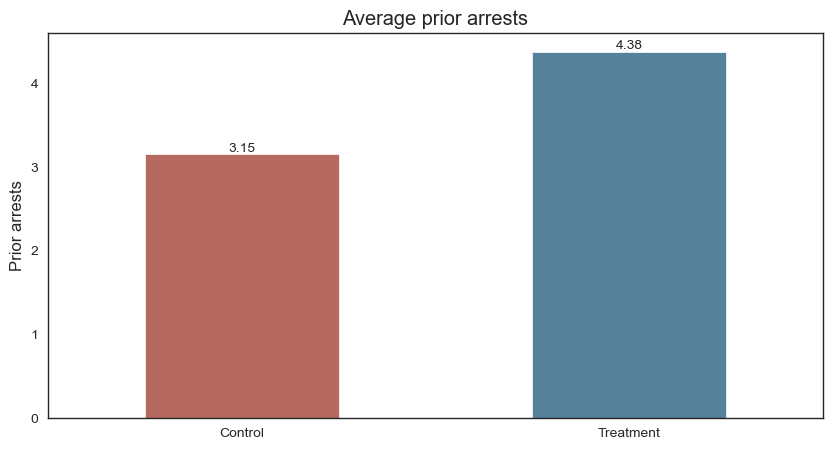

In [210]:
plots = data.groupby('treat').prior_arrests.mean().rename(index={0:'Control',1:'Treatment'}).reset_index()


plt.figure(figsize=(10,5))
sns.set_style("white")
sns.barplot(data = plots, x = 'treat', y= 'prior_arrests',saturation=0.50,width=0.5)
plt.title('Average prior arrests')
plt.ylabel('Prior arrests')
plt.xlabel('')


for index, row in plots.iterrows():
    plt.annotate(round(row['prior_arrests'],2), (index, round(row['prior_arrests'],2)), ha='center', va='bottom')
plt.savefig('../images/prior_arrests_plot.png')

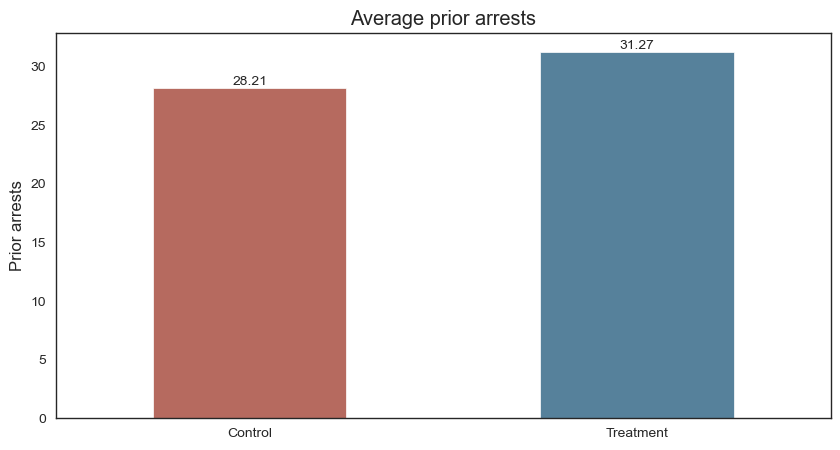

In [212]:
plots = data.groupby('treat').age_of_arrest.mean().rename(index={0:'Control',1:'Treatment'}).reset_index()


plt.figure(figsize=(10,5))
sns.set_style("white")
sns.barplot(data = plots, x = 'treat', y= 'age_of_arrest',saturation=0.50,width=0.5)
plt.title('Average prior arrests')
plt.ylabel('Prior arrests')
plt.xlabel('')


for index, row in plots.iterrows():
    plt.annotate(round(row['age_of_arrest'],2), (index, round(row['age_of_arrest'],2)), ha='center', va='bottom')
plt.savefig('../images/age_of_arrests_plot.png')

---